This notebook shows how to analyse several mass photometry measurements to quantify 
the equilibrium dissociation constant of a system A + B <-> AB

B is under the limit of detection (40 kDa in this case)

The notebook is based on the following publication:

Asor, R., & Kukura, P. (2022). Characterising biomolecular interactions and dynamics with mass photometry. Current Opinion in Chemical Biology, 68, 102132.

First we simulate the measurements and then we fit them.

In [1]:
from scripts import create_notebook_7_files, display_figure_static
import numpy as np

A_concentration_molar = 5e-9  # molar units
B_concentrations_nM = 0.25*(1.65**np.arange(2,9))  # nanomolar units

simulated_Kd = 1.2e-9

create_notebook_7_files(
    mass_A = 150,
    mass_B = 30,
    Kd = simulated_Kd,  # molar units
    A_concentration_molar = A_concentration_molar,  # molar units
    B_concentrations_nM = B_concentrations_nM,  # nanomolar units
    detection_limit = 40
)

# The final concentrations used in the simulation
# of A and B include a random error of 2% to simulate experimental conditions

Generated file: test_files/masses_A_B_0.681nM.csv
Generated file: test_files/masses_A_B_1.123nM.csv
Generated file: test_files/masses_A_B_1.853nM.csv
Generated file: test_files/masses_A_B_3.057nM.csv
Generated file: test_files/masses_A_B_5.045nM.csv
Generated file: test_files/masses_A_B_8.324nM.csv
Generated file: test_files/masses_A_B_13.734nM.csv


In [2]:
import glob
from pyphotomol import (
    MPAnalyzer,
    plot_histogram,
    plot_histograms_and_fits,
    LayoutConfig,
    PlotConfig,
    LegendConfig
)

mp = MPAnalyzer()

# Get all A+B files with B concentrations in filename, sorted by B concentration
ab_files = sorted(glob.glob("test_files/masses_A_B_*nM.csv"), 
                  key=lambda x: float(x.split('_')[-1].replace('nM.csv', '')))

# Extract total B concentrations from filenames
B_concentrations = [float(f.split('_')[-1].replace('nM.csv', '')) for f in ab_files]
# convert to string with 'nM' suffix for display
B_concentrations_str = [f"{b:.1f}nM" for b in B_concentrations]

mp.import_files(ab_files,names=B_concentrations_str)

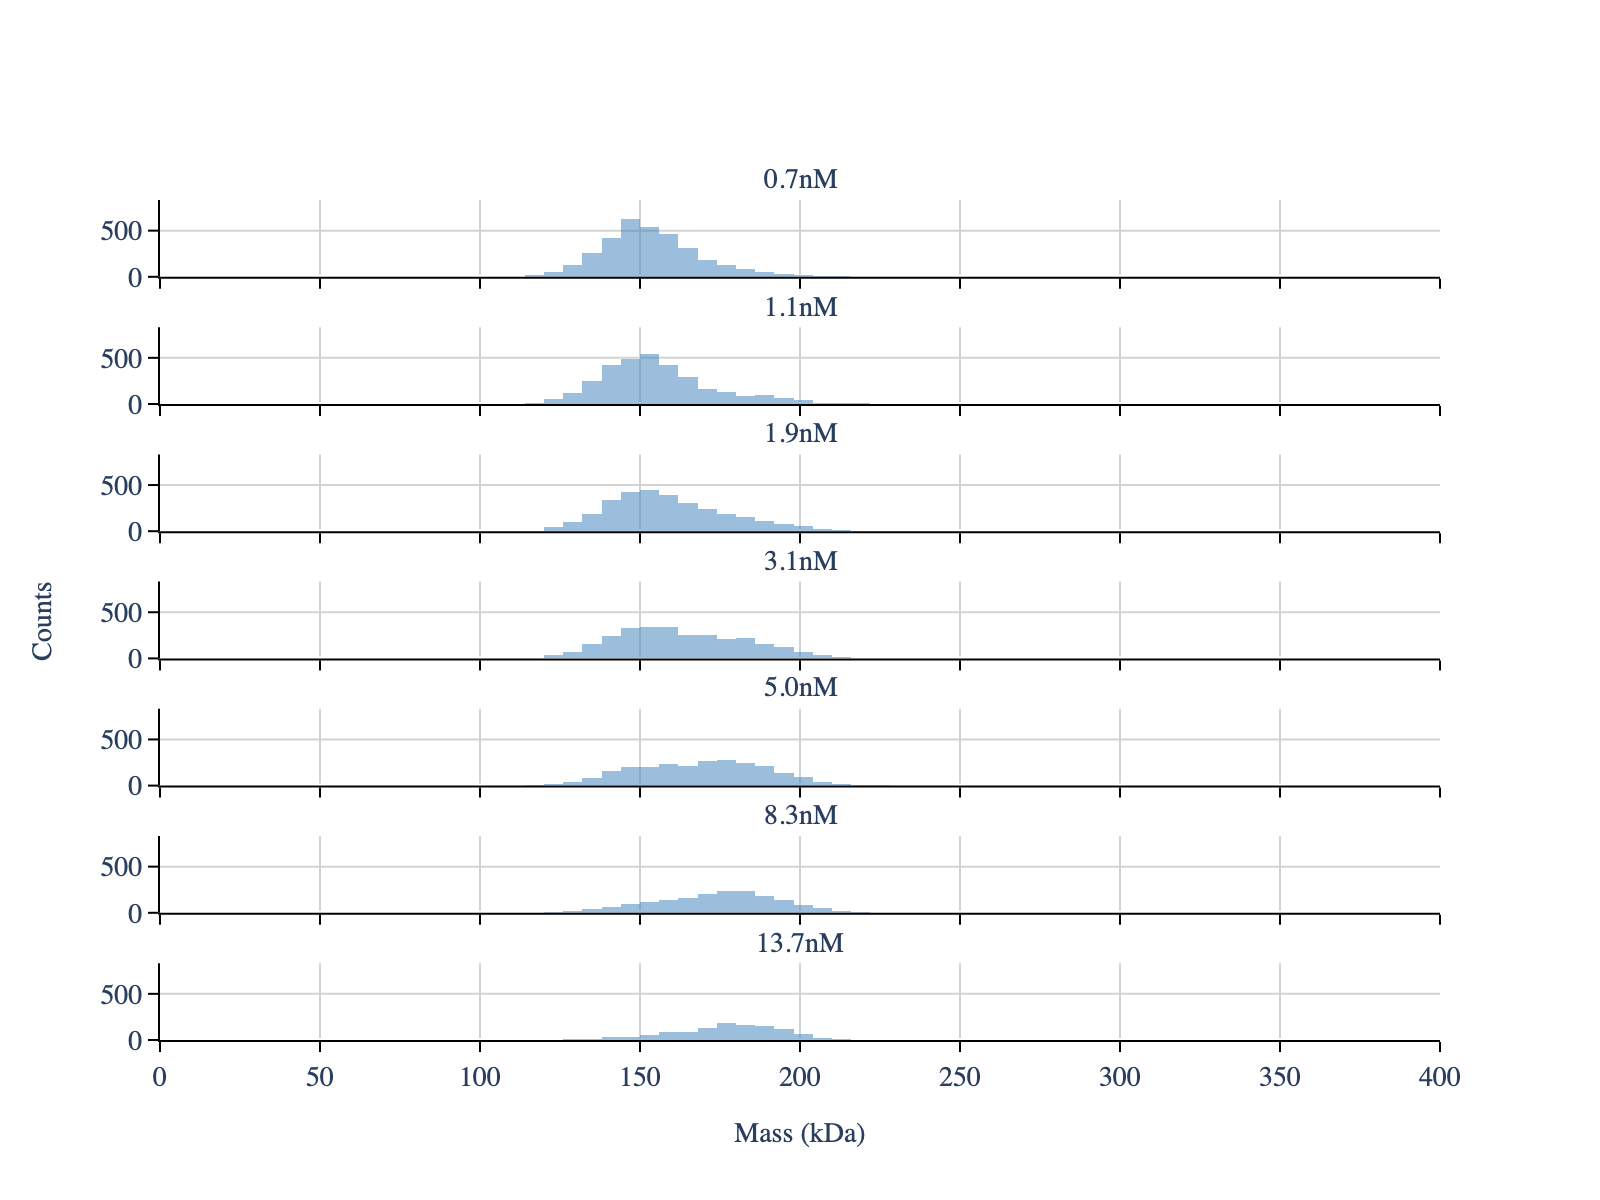

In [3]:
mp.apply_to_all(
    'create_histogram',
    window=[0,400], # You may need to adjust this based on your data
    bin_width=6) # You may need to adjust this based on your data

plot_config = PlotConfig(
    x_range=[0, 400]  # Set x-axis limits to 0-400 kDa
)

layout_config = LayoutConfig(
    stacked=True,
    show_subplot_titles=True,
    vertical_spacing=0.06,
    extra_padding_y_label=0.03
)

fig = plot_histogram(mp, layout_config=layout_config, plot_config=plot_config)
display_figure_static(fig)

In [4]:
# Fit the histograms to a multi-gaussian model
mp.apply_to_all(
    'fit_histogram',
    peaks_guess=[150,180],
    mean_tolerance=50,
    std_tolerance=100)

            legends    color  select  show_legend
0  Gaussian sum (1)  #808080    True         True
1           Peak #1  #E41A1C    True         True
2           Peak #2  #377EB8    True         True
3  Gaussian sum (2)  #808080    True        False
4           Peak #3  #E41A1C    True        False


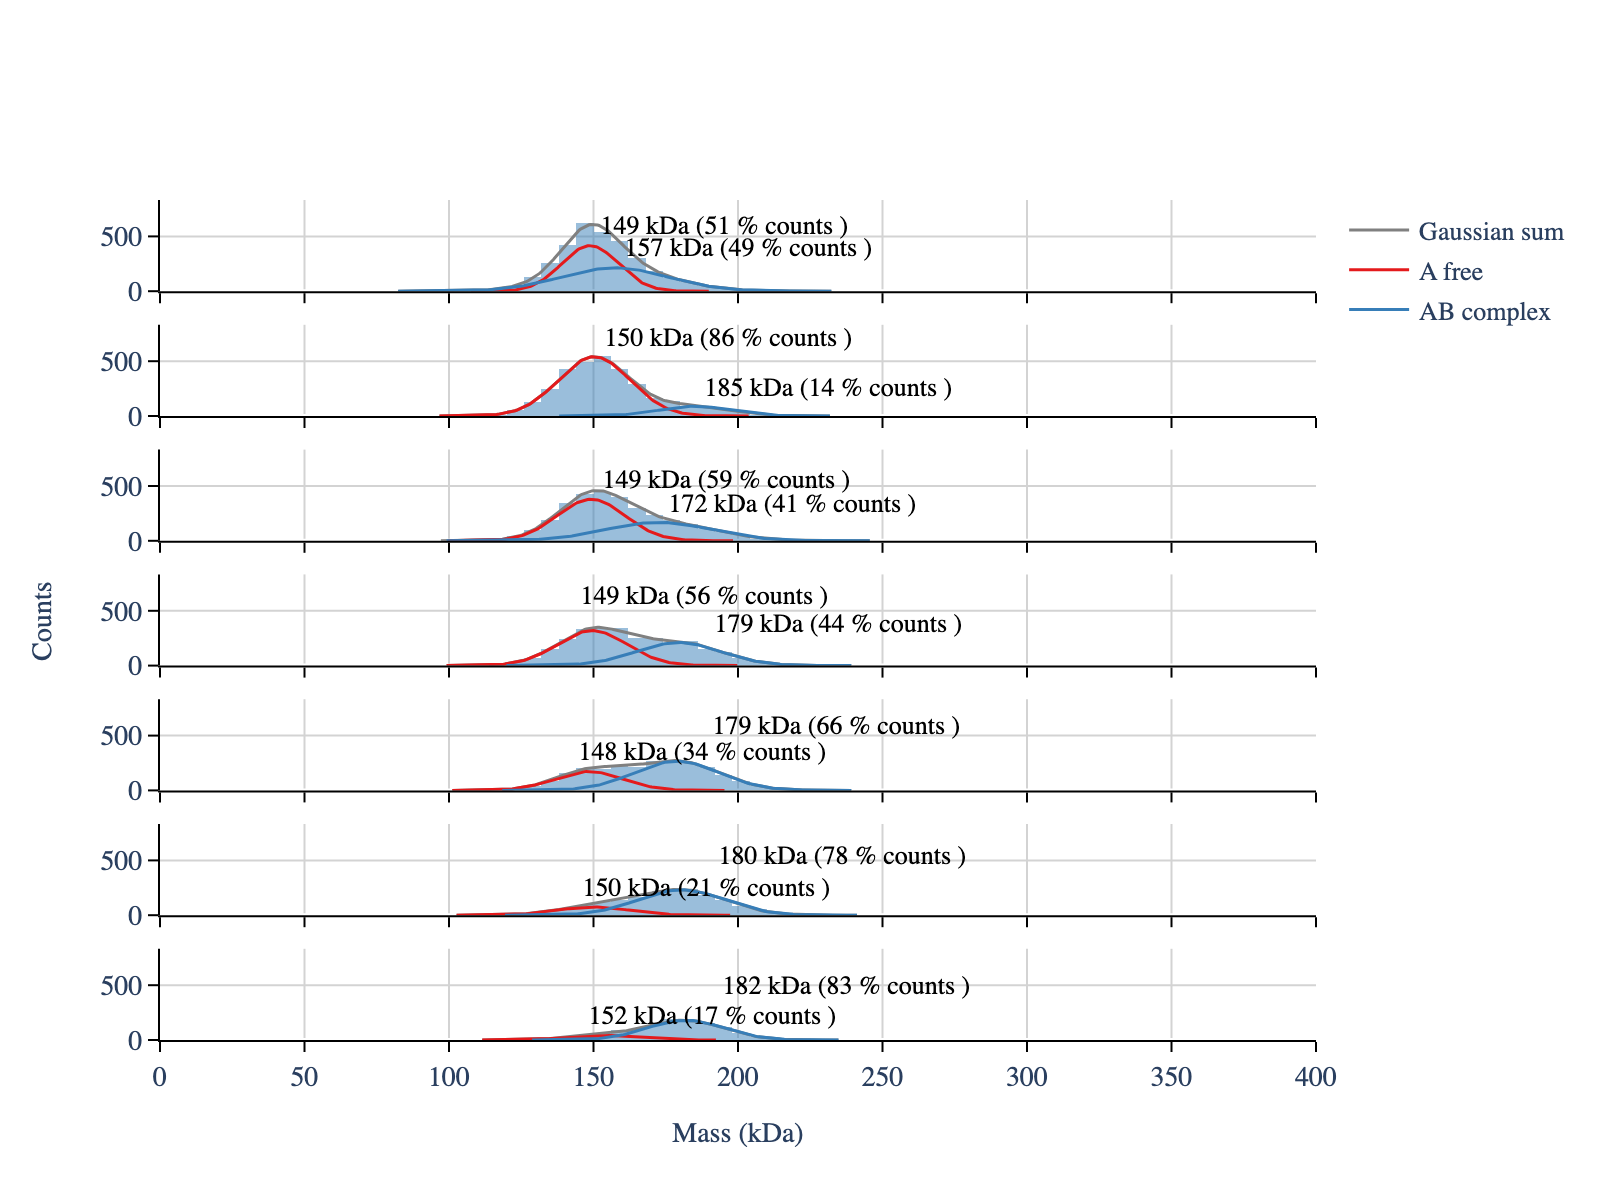

In [5]:
# Hide subplot titles
legends_df, _ = mp.create_plotting_config(repeat_colors=True)

# The show_legend column in legends_df controls which legends are shown in the plot
legends_df['show_legend'] = False
legends_df.loc[:2, 'show_legend'] = True  # Show the first three legends

print(legends_df.head())

legends_df.loc[0:2,'legends'] = [
    'Gaussian sum',
    'A free',
    'AB complex'
]

legend_config = LegendConfig(
    line_width=1.5,
    add_masses_to_legend=False,
    add_percentage_to_legend=False)

layout_config = LayoutConfig(
    stacked=True,
    show_subplot_titles=False,
    vertical_spacing=0.04,
    extra_padding_y_label=0.04,
    shared_yaxes=True  
)

# Plot the histograms with fits
fig = plot_histograms_and_fits(
    mp,
    legends_df=legends_df,
    legend_config=legend_config,
    layout_config=layout_config,
    plot_config=plot_config
)
display_figure_static(fig,height=600)

Now we calculate the total concentration of A free, B free and AB

In [6]:
counts_A  = []
counts_AB = []

for model_name in list(mp.models.keys()):
    model = mp.models[model_name]
    counts_A.append(model.fit_table['Counts'].iloc[0])
    counts_AB.append(model.fit_table['Counts'].iloc[1])

counts_A  = np.array(counts_A)
counts_AB = np.array(counts_AB)

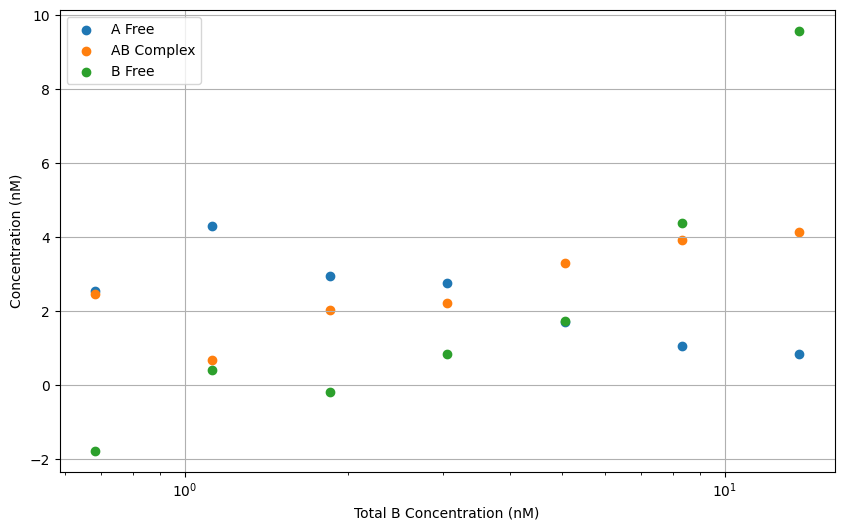

In [7]:
B_concentrations_molar = np.array(B_concentrations_nM) * 1e-9  # Convert to molar units
A_concentration_molar  = 5e-9  # Molar concentration of A

concentration_A_free = counts_A / (counts_A + counts_AB)  * A_concentration_molar  # Convert counts to concentration in Molar
concentration_AB     = counts_AB / (counts_A + counts_AB) * A_concentration_molar  # Convert counts to concentration in Molar

# Now we calculate the concentration of B_free based on the total B concentration and the concentration of AB complex
concentration_B_free = B_concentrations_molar - concentration_AB

# Plot them - against total B concentration
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(B_concentrations_molar*1e9, concentration_A_free*1e9, label='A Free', marker='o')
plt.scatter(B_concentrations_molar*1e9, concentration_AB*1e9, label='AB Complex', marker='o')
plt.scatter(B_concentrations_molar*1e9, concentration_B_free*1e9, label='B Free', marker='o')
plt.xscale('log')
plt.xlabel('Total B Concentration (nM)')
plt.ylabel('Concentration (nM)')
plt.legend()
plt.grid()
plt.show()

# It can happen that some concentrations are negative due to the simulated noise in the concentrations

The equilibrium dissociation constant Kd is defined as 

[A]*[B] / [AB]

We can start by estimating the Kd individually for all total B concentrations, 
where there is a significant concentration of [A], [B] and [AB]


In [8]:
conc_limit = 0.5e-9  # 
condition1 = concentration_A_free > conc_limit
condition2 = concentration_B_free > conc_limit
condition3 = concentration_AB > conc_limit
valid_indices = np.where(condition1 & condition2 & condition3)[0]
print(f"Valid indices: {valid_indices}")

Valid indices: [3 4 5 6]


In [9]:
Kds = concentration_A_free * concentration_B_free / concentration_AB

valid_Kds = Kds[valid_indices]
print("Valid Kds:")
print(valid_Kds)

# Calculate the average Kd and its standard deviation
average_Kd = np.mean(valid_Kds)
std_Kd = np.std(valid_Kds)
# Print using plus minus symbol - in nanomolar units
average_Kd_nM = average_Kd * 1e9  # Convert to nanomolar
std_Kd_nM = std_Kd * 1e9  # Convert to nanomolar
print(f"Average Kd: {average_Kd_nM:.2f} nM ± {std_Kd_nM:.2f} nM")

print('')
print('Simulated Kd (nM):')
print(simulated_Kd * 1e9)  # Convert to nanomolar

Valid Kds:
[1.04677515e-09 9.01569757e-10 1.18356519e-09 1.93843472e-09]
Average Kd: 1.27 nM ± 0.40 nM

Simulated Kd (nM):
1.2
